In [1]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
import xgboost as xgb
from sklearn.model_selection import train_test_split

2023-07-09 23:40:22.060808: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-09 23:40:22.062228: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-09 23:40:22.086434: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-09 23:40:22.086913: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-09 23:40:22.539342: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
data_dir = '../data/'
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(data_dir, 'test.csv'))
label = 'Survived'

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [62]:
pd.notna(train_df['Survived']).all()

True

# Explore Dataset

In [48]:
import seaborn as sns

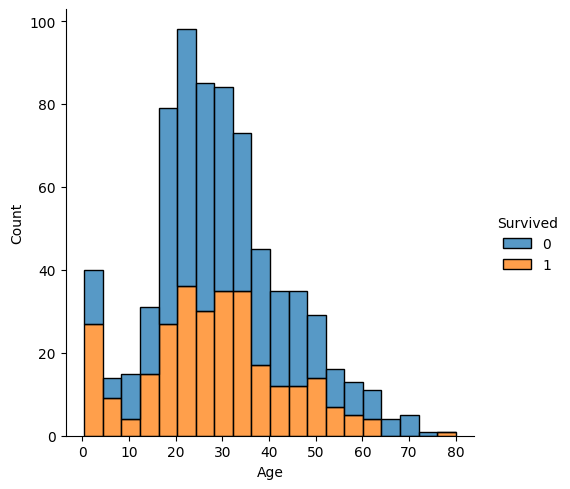

In [64]:
sns.displot(train_df,
            x="Age", hue="Survived", multiple="stack")

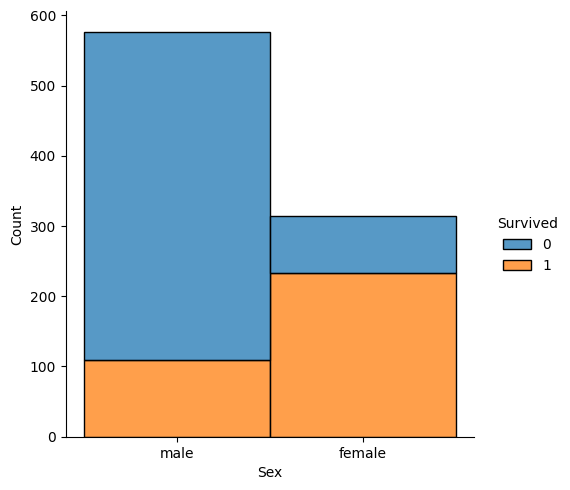

In [63]:
sns.displot(train_df,
            x="Sex", hue="Survived", multiple="stack")

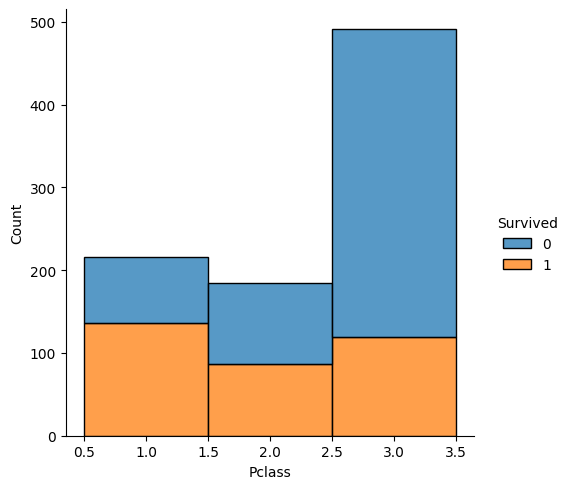

In [61]:
train_df['Pclass'] = train_df['Pclass'].astype('category')
sns.displot(train_df,
            x="Pclass", hue="Survived", multiple="stack", )

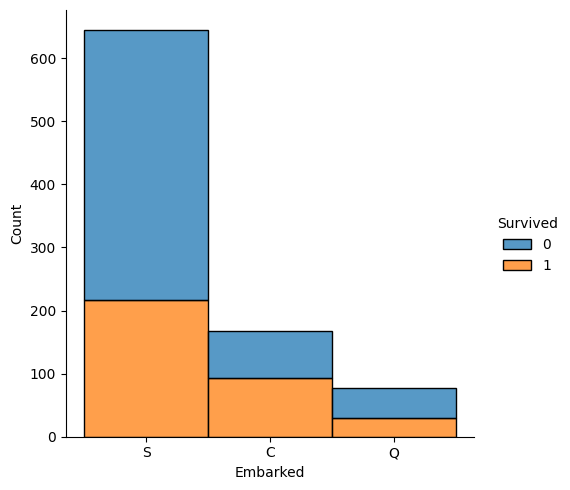

In [65]:
sns.displot(train_df,
            x="Embarked", hue="Survived", multiple="stack", )

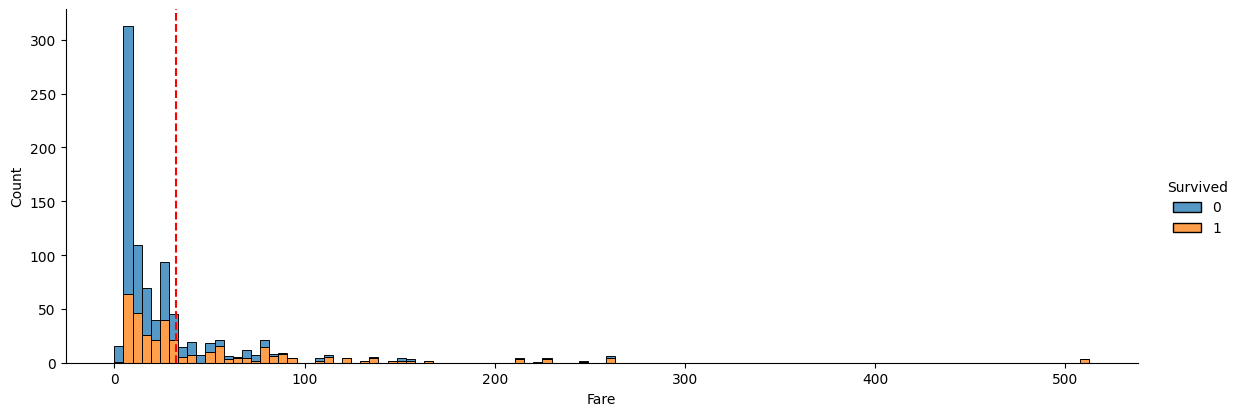

In [75]:
fare_distplot = sns.displot(train_df,
                            x="Fare", hue="Survived", multiple="stack", height=4.27, aspect=11.7/4.27)
fare_distplot.axes[0][0].axvline(train_df["Fare"].mean(), color='red', ls='--')

# Preprocess Dataset

In [25]:
def preprocess(df):
    df = df.copy()

    def ticket_number(x):
        return x.split(' ')[-1]

    def ticket_item(x):
        items = x.split(' ')
        if len(items) == 1:
            return 'NONE'
        return '_'.join(items[0:-1])

    df['Ticket_number'] = df['Ticket'].apply(ticket_number)
    df['Ticket_item'] = df['Ticket'].apply(ticket_item)
    df['Has_Sibsp'] = df['SibSp'] > 0
    df['Has_Parch'] = df['Parch'] > 0

    for col in df.select_dtypes(exclude=[np.number, bool]).columns.tolist():
        if col in ['Name', 'Ticket_number']:
            continue
        print(f'Coverting {col} to categorical')
        df[col] = df[col].astype('category')
    df['Pclass'] = df['Pclass'].astype('category')
    # df['Age'] = df['Age'].fillna(df['Age'].mean()).astype('int')
    # assert (len(pd.isna(df['Age'])) == 0,
    #      f'assertion failed with {len(pd.isna(df["Age"]))} Nan values')
    return df


def make_balanced_dataframe(df):
    df = df.copy()
    # make the set balanced
    not_survived = df[df[label] == 0]
    survived = df[df[label] == 1]

    if len(not_survived) > len(survived):
        not_survived = not_survived.sample(n=len(survived), random_state=42)
    elif len(not_survived) < len(survived):
        survived = survived.sample(n=len(not_survived), random_state=42)
    df_cp = pd.concat([survived, not_survived]).sample(frac=1, random_state=42)
    return df_cp


categorical_columns = ['Sex', 'Ticket_item', 'Cabin', 'Embarked', 'PClass']
preprocessed_train_df = preprocess(train_df)
# preprocessed_train_df = make_balanced_dataframe(preprocessed_train_df)
preprocessed_test_df = preprocess(test_df)

preprocessed_train_df.head(5)

Coverting Sex to categorical
Coverting Ticket to categorical
Coverting Cabin to categorical
Coverting Embarked to categorical
Coverting Ticket_item to categorical
Coverting Sex to categorical
Coverting Ticket to categorical
Coverting Cabin to categorical
Coverting Embarked to categorical
Coverting Ticket_item to categorical


<>:25: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:25: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/tmp/ipykernel_494683/3129714337.py:25: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (len(pd.isna(df['Age'])) == 0,


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_number,Ticket_item,Has_Sibsp,Has_Parch
95,96,0,3,"Shorney, Mr. Charles Joseph",male,29,0,0,374910,8.05,NaN,S,374910,NONE,False,False
585,586,1,1,"Taussig, Miss. Ruth",female,18,0,2,110413,79.65,E68,S,110413,NONE,False,True
546,547,1,2,"Beane, Mrs. Edward (Ethel Clarke)",female,19,1,0,2908,26.00,NaN,S,2908,NONE,True,False
316,317,1,2,"Kantor, Mrs. Sinai (Miriam Sternin)",female,24,1,0,244367,26.00,NaN,S,244367,NONE,True,False
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29,1,2,W./C. 6607,23.45,NaN,S,6607,W./C.,True,True


In [26]:
input_features = list(preprocessed_train_df.columns)
# remove unnecessary features
input_features.remove('Ticket')
input_features.remove('PassengerId')
input_features.remove('Name')
input_features.remove('Ticket_number')
input_features.remove('SibSp')
input_features.remove('Parch')
# remove what we want to predict.
input_features.remove(label)

print(f'Input features: {input_features}')

Input features: ['Pclass', 'Sex', 'Age', 'Fare', 'Cabin', 'Embarked', 'Ticket_item', 'Has_Sibsp', 'Has_Parch']


In [27]:
preprocessed_train_df[input_features].describe()

,Age,Fare
count,684.000000,684.000000
mean,29.735380,34.669140
std,13.155512,53.064796
min,0.000000,0.000000
25%,22.000000,8.003150
50%,29.000000,15.500000
75%,36.000000,33.000000
max,80.000000,512.329200


In [28]:
preprocessed_train_df[input_features].describe(exclude=np.number)

,Pclass,Sex,Cabin,Embarked,Ticket_item,Has_Sibsp,Has_Parch
count,684,684,172,682,684,684,684
unique,3,2,130,3,38,2,2
top,3,male,B96 B98,S,NONE,False,False
freq,351,398,4,480,501,462,516


In [29]:
X = preprocessed_train_df[input_features]
y = preprocessed_train_df[label]

# we need to create a train / val split
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)
X_test = preprocessed_test_df[input_features]

In [30]:
# hyperparamater tuning
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

hyperparameter_grid = {
    'classifier__eta': [0.05, 0.1, 0.3],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__max_depth': [7, 8, 9, 10, 11],
    'classifier__n_estimators': [500, 1000],
}

pipeline = Pipeline([('classifier', xgb.XGBClassifier(
    objective='binary:logistic',
    tree_method='gpu_hist',
    eval_metric='auc',  # could be "error" too
    enable_categorical=True,))])

random_cv = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=hyperparameter_grid,
    # cv=3,
    n_iter=10,
    return_train_score=True,
    random_state=42,
)

In [31]:
random_cv.fit(X_train, y_train,
              classifier__eval_set=[(X_val, y_val)],
              classifier__early_stopping_rounds=10,
              )

[0]	validation_0-auc:0.86174
[1]	validation_0-auc:0.86976
[2]	validation_0-auc:0.86777
[3]	validation_0-auc:0.86722
[4]	validation_0-auc:0.86133
[5]	validation_0-auc:0.86435
[6]	validation_0-auc:0.84838
[7]	validation_0-auc:0.85263
[8]	validation_0-auc:0.85270
[9]	validation_0-auc:0.85201
[10]	validation_0-auc:0.85208
[11]	validation_0-auc:0.85270
[0]	validation_0-auc:0.85921
[1]	validation_0-auc:0.86229
[2]	validation_0-auc:0.85982
[3]	validation_0-auc:0.85982
[4]	validation_0-auc:0.85832
[5]	validation_0-auc:0.86037
[6]	validation_0-auc:0.85743
[7]	validation_0-auc:0.85695
[8]	validation_0-auc:0.86318
[9]	validation_0-auc:0.86154
[10]	validation_0-auc:0.85866
[11]	validation_0-auc:0.85654
[12]	validation_0-auc:0.85558
[13]	validation_0-auc:0.85585
[14]	validation_0-auc:0.85201
[15]	validation_0-auc:0.85181


/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-auc:0.85708
[17]	validation_0-auc:0.85688
[18]	validation_0-auc:0.85647
[0]	validation_0-auc:0.85147
[1]	validation_0-auc:0.84509
[2]	validation_0-auc:0.84934
[3]	validation_0-auc:0.84818
[4]	validation_0-auc:0.85359
[5]	validation_0-auc:0.84989
[6]	validation_0-auc:0.84825
[7]	validation_0-auc:0.85112
[8]	validation_0-auc:0.84626
[9]	validation_0-auc:0.84544
[10]	validation_0-auc:0.84605
[11]	validation_0-auc:0.84612
[12]	validation_0-auc:0.84290
[13]	validation_0-auc:0.84249
[14]	validation_0-auc:0.84044
[0]	validation_0-auc:0.84455
[1]	validation_0-auc:0.84825
[2]	validation_0-auc:0.84729
[3]	validation_0-auc:0.84646
[4]	validation_0-auc:0.84818
[5]	validation_0-auc:0.84859
[6]	validation_0-auc:0.84235
[7]	validation_0-auc:0.84270
[8]	validation_0-auc:0.84434
[9]	validation_0-auc:0.84777
[10]	validation_0-auc:0.84825
[11]	validation_0-auc:0.84866
[12]	validation_0-auc:0.84852
[13]	validation_0-auc:0.84742
[14]	validation_0-auc:0.84948
[15]	validation_0-auc:0.84825


/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-auc:0.83824
[21]	validation_0-auc:0.84064
[22]	validation_0-auc:0.83913
[23]	validation_0-auc:0.83831
[24]	validation_0-auc:0.83817
[25]	validation_0-auc:0.84023
[26]	validation_0-auc:0.84002
[0]	validation_0-auc:0.84352
[1]	validation_0-auc:0.84318
[2]	validation_0-auc:0.84242
[3]	validation_0-auc:0.84379
[4]	validation_0-auc:0.84324
[5]	validation_0-auc:0.84249
[6]	validation_0-auc:0.84304
[7]	validation_0-auc:0.84331
[8]	validation_0-auc:0.84229
[9]	validation_0-auc:0.85160
[10]	validation_0-auc:0.84078
[11]	validation_0-auc:0.84078
[12]	validation_0-auc:0.84318
[13]	validation_0-auc:0.84646
[14]	validation_0-auc:0.84811
[15]	validation_0-auc:0.84989
[16]	validation_0-auc:0.84989
[17]	validation_0-auc:0.85126
[18]	validation_0-auc:0.85304
[19]	validation_0-auc:0.85270
[20]	validation_0-auc:0.85208
[21]	validation_0-auc:0.85201
[22]	validation_0-auc:0.85332
[23]	validation_0-auc:0.85359
[24]	validation_0-auc:0.85503
[25]	validation_0-auc:0.85462
[26]	validation_0-au

/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.86092
[1]	validation_0-auc:0.86606
[2]	validation_0-auc:0.86352
[3]	validation_0-auc:0.84893
[4]	validation_0-auc:0.85770
[5]	validation_0-auc:0.85551
[6]	validation_0-auc:0.85619
[7]	validation_0-auc:0.85318
[8]	validation_0-auc:0.85215
[9]	validation_0-auc:0.84886
[10]	validation_0-auc:0.84825
[0]	validation_0-auc:0.85475
[1]	validation_0-auc:0.85962
[2]	validation_0-auc:0.85839
[3]	validation_0-auc:0.85996
[4]	validation_0-auc:0.85935
[5]	validation_0-auc:0.86229
[6]	validation_0-auc:0.86366
[7]	validation_0-auc:0.86270
[8]	validation_0-auc:0.86099
[9]	validation_0-auc:0.85976
[10]	validation_0-auc:0.85804
[11]	validation_0-auc:0.85982
[12]	validation_0-auc:0.85996
[13]	validation_0-auc:0.85708
[14]	validation_0-auc:0.85462
[15]	validation_0-auc:0.85640
[0]	validation_0-auc:0.85126
[1]	validation_0-auc:0.84496
[2]	validation_0-auc:0.85215
[3]	validation_0-auc:0.84818
[4]	validation_0-auc:0.84599
[5]	validation_0-auc:0.84825
[6]	validation_0-auc:0.84612
[7]	val

/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.84133
[1]	validation_0-auc:0.84482
[2]	validation_0-auc:0.85133
[3]	validation_0-auc:0.84393
[4]	validation_0-auc:0.84222
[5]	validation_0-auc:0.84126
[6]	validation_0-auc:0.84564
[7]	validation_0-auc:0.84784
[8]	validation_0-auc:0.83893
[9]	validation_0-auc:0.83680
[10]	validation_0-auc:0.84804
[11]	validation_0-auc:0.84222
[0]	validation_0-auc:0.84277
[1]	validation_0-auc:0.83975
[2]	validation_0-auc:0.84167
[3]	validation_0-auc:0.83687
[4]	validation_0-auc:0.84229
[5]	validation_0-auc:0.84516
[6]	validation_0-auc:0.84503
[7]	validation_0-auc:0.84694
[8]	validation_0-auc:0.84756
[9]	validation_0-auc:0.84873
[10]	validation_0-auc:0.84763
[11]	validation_0-auc:0.84879
[12]	validation_0-auc:0.84797
[13]	validation_0-auc:0.84509
[14]	validation_0-auc:0.84599
[15]	validation_0-auc:0.85236
[16]	validation_0-auc:0.85284
[17]	validation_0-auc:0.85249
[18]	validation_0-auc:0.85147


/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[19]	validation_0-auc:0.85325
[20]	validation_0-auc:0.85311
[21]	validation_0-auc:0.85243
[22]	validation_0-auc:0.85311
[23]	validation_0-auc:0.85380
[24]	validation_0-auc:0.85366
[25]	validation_0-auc:0.85489
[26]	validation_0-auc:0.85489
[27]	validation_0-auc:0.85558
[28]	validation_0-auc:0.85517
[29]	validation_0-auc:0.85523
[30]	validation_0-auc:0.85496
[31]	validation_0-auc:0.85565
[32]	validation_0-auc:0.85475
[33]	validation_0-auc:0.85373
[34]	validation_0-auc:0.85318
[35]	validation_0-auc:0.85290
[36]	validation_0-auc:0.85167
[37]	validation_0-auc:0.85181
[38]	validation_0-auc:0.85003
[39]	validation_0-auc:0.85058
[40]	validation_0-auc:0.84921
[0]	validation_0-auc:0.86092
[1]	validation_0-auc:0.86620
[2]	validation_0-auc:0.86311
[3]	validation_0-auc:0.84825
[4]	validation_0-auc:0.85606
[5]	validation_0-auc:0.85229
[6]	validation_0-auc:0.85414
[7]	validation_0-auc:0.85085
[8]	validation_0-auc:0.85304
[9]	validation_0-auc:0.85270
[10]	validation_0-auc:0.85270
[11]	validation_0-au

/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-auc:0.85469
[19]	validation_0-auc:0.85455
[20]	validation_0-auc:0.85277
[21]	validation_0-auc:0.85092
[22]	validation_0-auc:0.85215
[0]	validation_0-auc:0.85126
[1]	validation_0-auc:0.84496
[2]	validation_0-auc:0.85215
[3]	validation_0-auc:0.84818
[4]	validation_0-auc:0.84448
[5]	validation_0-auc:0.84729
[6]	validation_0-auc:0.84503
[7]	validation_0-auc:0.83934
[8]	validation_0-auc:0.84030
[9]	validation_0-auc:0.84331
[10]	validation_0-auc:0.84660
[11]	validation_0-auc:0.84270
[0]	validation_0-auc:0.83886
[1]	validation_0-auc:0.83680
[2]	validation_0-auc:0.83701
[3]	validation_0-auc:0.82783
[4]	validation_0-auc:0.83468
[5]	validation_0-auc:0.84057
[6]	validation_0-auc:0.84153
[7]	validation_0-auc:0.84153
[8]	validation_0-auc:0.83441
[9]	validation_0-auc:0.83660
[10]	validation_0-auc:0.83646
[11]	validation_0-auc:0.83989
[12]	validation_0-auc:0.83900
[13]	validation_0-auc:0.83872
[14]	validation_0-auc:0.84098
[15]	validation_0-auc:0.83674
[16]	validation_0-auc:0.83687


/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.84277
[1]	validation_0-auc:0.84071
[2]	validation_0-auc:0.84139
[3]	validation_0-auc:0.83756
[4]	validation_0-auc:0.84085
[5]	validation_0-auc:0.84324
[6]	validation_0-auc:0.84345
[7]	validation_0-auc:0.84660
[8]	validation_0-auc:0.84420
[9]	validation_0-auc:0.84701
[10]	validation_0-auc:0.84756
[11]	validation_0-auc:0.84427
[12]	validation_0-auc:0.84448
[13]	validation_0-auc:0.84427
[14]	validation_0-auc:0.84633
[15]	validation_0-auc:0.84989
[16]	validation_0-auc:0.85051
[17]	validation_0-auc:0.85263
[18]	validation_0-auc:0.85359
[19]	validation_0-auc:0.85270
[20]	validation_0-auc:0.85201
[21]	validation_0-auc:0.85174
[22]	validation_0-auc:0.85338
[23]	validation_0-auc:0.85428
[24]	validation_0-auc:0.85489
[25]	validation_0-auc:0.85523
[26]	validation_0-auc:0.85571
[27]	validation_0-auc:0.85421
[28]	validation_0-auc:0.85462
[29]	validation_0-auc:0.85496
[30]	validation_0-auc:0.85469
[31]	validation_0-auc:0.85599
[32]	validation_0-auc:0.85558
[33]	validation_0-au

/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.86174
[1]	validation_0-auc:0.86976
[2]	validation_0-auc:0.86777
[3]	validation_0-auc:0.86722
[4]	validation_0-auc:0.86133
[5]	validation_0-auc:0.86435
[6]	validation_0-auc:0.84838
[7]	validation_0-auc:0.85263
[8]	validation_0-auc:0.85270
[9]	validation_0-auc:0.85201
[10]	validation_0-auc:0.85208
[11]	validation_0-auc:0.85270
[0]	validation_0-auc:0.85921
[1]	validation_0-auc:0.86229
[2]	validation_0-auc:0.85982
[3]	validation_0-auc:0.85982
[4]	validation_0-auc:0.85832
[5]	validation_0-auc:0.86037
[6]	validation_0-auc:0.85743
[7]	validation_0-auc:0.85695
[8]	validation_0-auc:0.86318
[9]	validation_0-auc:0.86154
[10]	validation_0-auc:0.85866
[11]	validation_0-auc:0.85654
[12]	validation_0-auc:0.85558
[13]	validation_0-auc:0.85585
[14]	validation_0-auc:0.85201
[15]	validation_0-auc:0.85181
[16]	validation_0-auc:0.85708
[17]	validation_0-auc:0.85688
[18]	validation_0-auc:0.85647
[0]	validation_0-auc:0.85147
[1]	validation_0-auc:0.84509
[2]	validation_0-auc:0.84934
[3]

/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.84455
[1]	validation_0-auc:0.84825
[2]	validation_0-auc:0.84729
[3]	validation_0-auc:0.84646
[4]	validation_0-auc:0.84818
[5]	validation_0-auc:0.84859
[6]	validation_0-auc:0.84235
[7]	validation_0-auc:0.84270
[8]	validation_0-auc:0.84434
[9]	validation_0-auc:0.84777
[10]	validation_0-auc:0.84825
[11]	validation_0-auc:0.84866
[12]	validation_0-auc:0.84852
[13]	validation_0-auc:0.84742
[14]	validation_0-auc:0.84948
[15]	validation_0-auc:0.84825
[16]	validation_0-auc:0.84797
[17]	validation_0-auc:0.85010
[18]	validation_0-auc:0.84736
[19]	validation_0-auc:0.84831
[20]	validation_0-auc:0.83824
[21]	validation_0-auc:0.84064
[22]	validation_0-auc:0.83913
[23]	validation_0-auc:0.83831
[24]	validation_0-auc:0.83817
[25]	validation_0-auc:0.84023
[26]	validation_0-auc:0.84002
[27]	validation_0-auc:0.84112
[0]	validation_0-auc:0.84352
[1]	validation_0-auc:0.84318
[2]	validation_0-auc:0.84242
[3]	validation_0-auc:0.84379
[4]	validation_0-auc:0.84324
[5]	validation_0-auc:0.84

/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-auc:0.85126
[18]	validation_0-auc:0.85304
[19]	validation_0-auc:0.85270
[20]	validation_0-auc:0.85208
[21]	validation_0-auc:0.85201
[22]	validation_0-auc:0.85332
[23]	validation_0-auc:0.85359
[24]	validation_0-auc:0.85503
[25]	validation_0-auc:0.85462
[26]	validation_0-auc:0.85338
[27]	validation_0-auc:0.85284
[28]	validation_0-auc:0.85414
[29]	validation_0-auc:0.85174
[30]	validation_0-auc:0.85229
[31]	validation_0-auc:0.85311
[32]	validation_0-auc:0.85167
[33]	validation_0-auc:0.85249
[34]	validation_0-auc:0.85332
[0]	validation_0-auc:0.86174
[1]	validation_0-auc:0.86798
[2]	validation_0-auc:0.86907
[3]	validation_0-auc:0.86853
[4]	validation_0-auc:0.86839
[5]	validation_0-auc:0.86784
[6]	validation_0-auc:0.86907
[7]	validation_0-auc:0.86853
[8]	validation_0-auc:0.86853
[9]	validation_0-auc:0.86866
[10]	validation_0-auc:0.86907
[11]	validation_0-auc:0.86894
[0]	validation_0-auc:0.85921
[1]	validation_0-auc:0.86229
[2]	validation_0-auc:0.85982
[3]	validation_0-auc:0.

/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-auc:0.84414
[5]	validation_0-auc:0.84414
[6]	validation_0-auc:0.84551
[7]	validation_0-auc:0.84605
[8]	validation_0-auc:0.84770
[9]	validation_0-auc:0.84708
[10]	validation_0-auc:0.84681
[0]	validation_0-auc:0.84455
[1]	validation_0-auc:0.84825
[2]	validation_0-auc:0.84756
[3]	validation_0-auc:0.84742
[4]	validation_0-auc:0.84742
[5]	validation_0-auc:0.84742
[6]	validation_0-auc:0.84742
[7]	validation_0-auc:0.84688
[8]	validation_0-auc:0.84660
[9]	validation_0-auc:0.84797
[10]	validation_0-auc:0.84797
[0]	validation_0-auc:0.84352
[1]	validation_0-auc:0.84297
[2]	validation_0-auc:0.84352
[3]	validation_0-auc:0.84407
[4]	validation_0-auc:0.84324
[5]	validation_0-auc:0.84338
[6]	validation_0-auc:0.84324
[7]	validation_0-auc:0.84338
[8]	validation_0-auc:0.84324
[9]	validation_0-auc:0.84338
[10]	validation_0-auc:0.84338
[11]	validation_0-auc:0.84338
[12]	validation_0-auc:0.84324
[0]	validation_0-auc:0.86092
[1]	validation_0-auc:0.86620
[2]	validation_0-auc:0.86352
[3]	valid

/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-auc:0.85215
[6]	validation_0-auc:0.85386
[7]	validation_0-auc:0.84982
[8]	validation_0-auc:0.85147
[9]	validation_0-auc:0.85112
[10]	validation_0-auc:0.84866
[0]	validation_0-auc:0.84612
[1]	validation_0-auc:0.85064
[2]	validation_0-auc:0.85078
[3]	validation_0-auc:0.85160
[4]	validation_0-auc:0.85222
[5]	validation_0-auc:0.85071
[6]	validation_0-auc:0.84934
[7]	validation_0-auc:0.85345
[8]	validation_0-auc:0.85270
[9]	validation_0-auc:0.85277
[10]	validation_0-auc:0.85112
[11]	validation_0-auc:0.85277
[12]	validation_0-auc:0.84982
[13]	validation_0-auc:0.84955
[14]	validation_0-auc:0.84996
[15]	validation_0-auc:0.84900
[16]	validation_0-auc:0.84694
[17]	validation_0-auc:0.84708
[0]	validation_0-auc:0.85126
[1]	validation_0-auc:0.84496
[2]	validation_0-auc:0.85215
[3]	validation_0-auc:0.84818
[4]	validation_0-auc:0.84448
[5]	validation_0-auc:0.84729
[6]	validation_0-auc:0.84503
[7]	validation_0-auc:0.83934
[8]	validation_0-auc:0.84016
[9]	validation_0-auc:0.84078
[10]	

/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[11]	validation_0-auc:0.84736
[12]	validation_0-auc:0.84722
[0]	validation_0-auc:0.84078
[1]	validation_0-auc:0.83735
[2]	validation_0-auc:0.83770
[3]	validation_0-auc:0.82769
[4]	validation_0-auc:0.82797
[5]	validation_0-auc:0.83338
[6]	validation_0-auc:0.83448
[7]	validation_0-auc:0.83263
[8]	validation_0-auc:0.83016
[9]	validation_0-auc:0.83379
[10]	validation_0-auc:0.83680
[0]	validation_0-auc:0.84277
[1]	validation_0-auc:0.84071
[2]	validation_0-auc:0.84139
[3]	validation_0-auc:0.83756
[4]	validation_0-auc:0.84064
[5]	validation_0-auc:0.84599
[6]	validation_0-auc:0.84612
[7]	validation_0-auc:0.84811
[8]	validation_0-auc:0.84674
[9]	validation_0-auc:0.84557
[10]	validation_0-auc:0.84448
[11]	validation_0-auc:0.84770
[12]	validation_0-auc:0.84619
[13]	validation_0-auc:0.84701
[14]	validation_0-auc:0.84461
[15]	validation_0-auc:0.84092
[16]	validation_0-auc:0.84605
[17]	validation_0-auc:0.85099
[18]	validation_0-auc:0.85201
[19]	validation_0-auc:0.85016
[20]	validation_0-auc:0.84893


/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-auc:0.85030
[22]	validation_0-auc:0.85016
[23]	validation_0-auc:0.85044
[24]	validation_0-auc:0.85099
[25]	validation_0-auc:0.85106
[26]	validation_0-auc:0.85106
[27]	validation_0-auc:0.85195
[28]	validation_0-auc:0.85304
[29]	validation_0-auc:0.85414
[30]	validation_0-auc:0.85428
[31]	validation_0-auc:0.85482
[32]	validation_0-auc:0.85654
[33]	validation_0-auc:0.85797
[34]	validation_0-auc:0.85715
[35]	validation_0-auc:0.85688
[36]	validation_0-auc:0.85688
[37]	validation_0-auc:0.85551
[38]	validation_0-auc:0.85619
[39]	validation_0-auc:0.85606
[40]	validation_0-auc:0.85702
[41]	validation_0-auc:0.85702
[42]	validation_0-auc:0.85496
[43]	validation_0-auc:0.85688
[0]	validation_0-auc:0.86092
[1]	validation_0-auc:0.86044
[2]	validation_0-auc:0.86017
[3]	validation_0-auc:0.85921
[4]	validation_0-auc:0.86058
[5]	validation_0-auc:0.86277
[6]	validation_0-auc:0.86291
[7]	validation_0-auc:0.86359
[8]	validation_0-auc:0.86400
[9]	validation_0-auc:0.86373
[10]	validation_0-au

/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.84612
[1]	validation_0-auc:0.85064
[2]	validation_0-auc:0.85256
[3]	validation_0-auc:0.85311
[4]	validation_0-auc:0.85338
[5]	validation_0-auc:0.85338
[6]	validation_0-auc:0.85311
[7]	validation_0-auc:0.85325
[8]	validation_0-auc:0.85421
[9]	validation_0-auc:0.85421
[10]	validation_0-auc:0.85421
[11]	validation_0-auc:0.85421
[12]	validation_0-auc:0.85421
[13]	validation_0-auc:0.85421
[14]	validation_0-auc:0.85421
[15]	validation_0-auc:0.85421
[16]	validation_0-auc:0.85421
[17]	validation_0-auc:0.85421
[0]	validation_0-auc:0.85126
[1]	validation_0-auc:0.84873
[2]	validation_0-auc:0.84482
[3]	validation_0-auc:0.84475
[4]	validation_0-auc:0.84366
[5]	validation_0-auc:0.84311
[6]	validation_0-auc:0.84352
[7]	validation_0-auc:0.84509
[8]	validation_0-auc:0.84345
[9]	validation_0-auc:0.84174
[0]	validation_0-auc:0.84078
[1]	validation_0-auc:0.84489
[2]	validation_0-auc:0.83845
[3]	validation_0-auc:0.83900
[4]	validation_0-auc:0.83872
[5]	validation_0-auc:0.83982
[6]	va

/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-auc:0.84126
[7]	validation_0-auc:0.83948
[8]	validation_0-auc:0.84126
[9]	validation_0-auc:0.84126
[10]	validation_0-auc:0.84126
[0]	validation_0-auc:0.86092
[1]	validation_0-auc:0.86044
[2]	validation_0-auc:0.86017
[3]	validation_0-auc:0.85921
[4]	validation_0-auc:0.86058
[5]	validation_0-auc:0.86277
[6]	validation_0-auc:0.86291
[7]	validation_0-auc:0.86359
[8]	validation_0-auc:0.86400
[9]	validation_0-auc:0.86373
[10]	validation_0-auc:0.86387
[11]	validation_0-auc:0.86359
[12]	validation_0-auc:0.86414
[13]	validation_0-auc:0.86373
[14]	validation_0-auc:0.86469
[15]	validation_0-auc:0.86428
[16]	validation_0-auc:0.86496
[17]	validation_0-auc:0.86483
[18]	validation_0-auc:0.86496
[19]	validation_0-auc:0.86428
[20]	validation_0-auc:0.86311
[21]	validation_0-auc:0.86311
[22]	validation_0-auc:0.86339
[23]	validation_0-auc:0.86489
[24]	validation_0-auc:0.86503
[25]	validation_0-auc:0.86284
[26]	validation_0-auc:0.86517
[27]	validation_0-auc:0.85503
[28]	validation_0-auc:0.

/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.84612
[1]	validation_0-auc:0.85064
[2]	validation_0-auc:0.85256
[3]	validation_0-auc:0.85311
[4]	validation_0-auc:0.85338
[5]	validation_0-auc:0.85338
[6]	validation_0-auc:0.85311
[7]	validation_0-auc:0.85325
[8]	validation_0-auc:0.85421
[9]	validation_0-auc:0.85421
[10]	validation_0-auc:0.85421
[11]	validation_0-auc:0.85421
[12]	validation_0-auc:0.85421
[13]	validation_0-auc:0.85421
[14]	validation_0-auc:0.85421
[15]	validation_0-auc:0.85421
[16]	validation_0-auc:0.85421
[17]	validation_0-auc:0.85421
[0]	validation_0-auc:0.85126
[1]	validation_0-auc:0.84873
[2]	validation_0-auc:0.84482
[3]	validation_0-auc:0.84475
[4]	validation_0-auc:0.84366
[5]	validation_0-auc:0.84311
[6]	validation_0-auc:0.84352
[7]	validation_0-auc:0.84509
[8]	validation_0-auc:0.84345
[9]	validation_0-auc:0.84174
[10]	validation_0-auc:0.84434
[0]	validation_0-auc:0.83886
[1]	validation_0-auc:0.84461
[2]	validation_0-auc:0.83749
[3]	validation_0-auc:0.83845
[4]	validation_0-auc:0.83886
[5]	v

/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.84277
[1]	validation_0-auc:0.84071
[2]	validation_0-auc:0.84222
[3]	validation_0-auc:0.84126
[4]	validation_0-auc:0.84126
[5]	validation_0-auc:0.84126
[6]	validation_0-auc:0.84126
[7]	validation_0-auc:0.83948
[8]	validation_0-auc:0.84126
[9]	validation_0-auc:0.84126
[10]	validation_0-auc:0.84126
[0]	validation_0-auc:0.86174
[1]	validation_0-auc:0.86976
[2]	validation_0-auc:0.86777
[3]	validation_0-auc:0.86722
[4]	validation_0-auc:0.86133
[5]	validation_0-auc:0.86435
[6]	validation_0-auc:0.84838
[7]	validation_0-auc:0.85263
[8]	validation_0-auc:0.85270
[9]	validation_0-auc:0.85201
[10]	validation_0-auc:0.85208
[11]	validation_0-auc:0.85270
[0]	validation_0-auc:0.85921
[1]	validation_0-auc:0.86229
[2]	validation_0-auc:0.85982
[3]	validation_0-auc:0.85982
[4]	validation_0-auc:0.85832
[5]	validation_0-auc:0.86037
[6]	validation_0-auc:0.85743
[7]	validation_0-auc:0.85695
[8]	validation_0-auc:0.86318
[9]	validation_0-auc:0.86154
[10]	validation_0-auc:0.85866
[11]	valid

/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.85147
[1]	validation_0-auc:0.84509
[2]	validation_0-auc:0.84934
[3]	validation_0-auc:0.84818
[4]	validation_0-auc:0.85359
[5]	validation_0-auc:0.84989
[6]	validation_0-auc:0.84825
[7]	validation_0-auc:0.85112
[8]	validation_0-auc:0.84626
[9]	validation_0-auc:0.84544
[10]	validation_0-auc:0.84605
[11]	validation_0-auc:0.84612
[12]	validation_0-auc:0.84290
[13]	validation_0-auc:0.84249
[14]	validation_0-auc:0.84044
[0]	validation_0-auc:0.84455
[1]	validation_0-auc:0.84825
[2]	validation_0-auc:0.84729
[3]	validation_0-auc:0.84646
[4]	validation_0-auc:0.84818
[5]	validation_0-auc:0.84859
[6]	validation_0-auc:0.84235
[7]	validation_0-auc:0.84270
[8]	validation_0-auc:0.84434
[9]	validation_0-auc:0.84777
[10]	validation_0-auc:0.84825
[11]	validation_0-auc:0.84866
[12]	validation_0-auc:0.84852
[13]	validation_0-auc:0.84742
[14]	validation_0-auc:0.84948
[15]	validation_0-auc:0.84825
[16]	validation_0-auc:0.84797
[17]	validation_0-auc:0.85010
[18]	validation_0-auc:0.84736


/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-auc:0.84229
[9]	validation_0-auc:0.85160
[10]	validation_0-auc:0.84078
[11]	validation_0-auc:0.84078
[12]	validation_0-auc:0.84318
[13]	validation_0-auc:0.84646
[14]	validation_0-auc:0.84811
[15]	validation_0-auc:0.84989
[16]	validation_0-auc:0.84989
[17]	validation_0-auc:0.85126
[18]	validation_0-auc:0.85304
[19]	validation_0-auc:0.85270
[20]	validation_0-auc:0.85208
[21]	validation_0-auc:0.85201
[22]	validation_0-auc:0.85332
[23]	validation_0-auc:0.85359
[24]	validation_0-auc:0.85503
[25]	validation_0-auc:0.85462
[26]	validation_0-auc:0.85338
[27]	validation_0-auc:0.85284
[28]	validation_0-auc:0.85414
[29]	validation_0-auc:0.85174
[30]	validation_0-auc:0.85229
[31]	validation_0-auc:0.85311
[32]	validation_0-auc:0.85167
[33]	validation_0-auc:0.85249
[34]	validation_0-auc:0.85332
[0]	validation_0-auc:0.86092
[1]	validation_0-auc:0.86620
[2]	validation_0-auc:0.86579
[3]	validation_0-auc:0.86421
[4]	validation_0-auc:0.86092
[5]	validation_0-auc:0.86380
[6]	validation_0-a

/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.85126
[1]	validation_0-auc:0.84564
[2]	validation_0-auc:0.84962
[3]	validation_0-auc:0.84859
[4]	validation_0-auc:0.84968
[5]	validation_0-auc:0.84804
[6]	validation_0-auc:0.84921
[7]	validation_0-auc:0.84729
[8]	validation_0-auc:0.84605
[9]	validation_0-auc:0.84359
[10]	validation_0-auc:0.84461
[0]	validation_0-auc:0.83886
[1]	validation_0-auc:0.83749
[2]	validation_0-auc:0.83735
[3]	validation_0-auc:0.83817
[4]	validation_0-auc:0.83893
[5]	validation_0-auc:0.83975
[6]	validation_0-auc:0.83386
[7]	validation_0-auc:0.83687
[8]	validation_0-auc:0.83564
[9]	validation_0-auc:0.83687
[10]	validation_0-auc:0.83811
[11]	validation_0-auc:0.84249
[12]	validation_0-auc:0.84283
[13]	validation_0-auc:0.84407
[14]	validation_0-auc:0.83941
[15]	validation_0-auc:0.83900
[16]	validation_0-auc:0.83838


/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-auc:0.84009
[18]	validation_0-auc:0.84016
[19]	validation_0-auc:0.83790
[20]	validation_0-auc:0.83674
[21]	validation_0-auc:0.83756
[22]	validation_0-auc:0.83701
[23]	validation_0-auc:0.83824
[0]	validation_0-auc:0.84277
[1]	validation_0-auc:0.84071
[2]	validation_0-auc:0.84044
[3]	validation_0-auc:0.84181
[4]	validation_0-auc:0.83667
[5]	validation_0-auc:0.84078
[6]	validation_0-auc:0.84187
[7]	validation_0-auc:0.83955
[8]	validation_0-auc:0.83934
[9]	validation_0-auc:0.83920
[0]	validation_0-auc:0.85530
[1]	validation_0-auc:0.85797
[2]	validation_0-auc:0.85729
[3]	validation_0-auc:0.85592
[4]	validation_0-auc:0.85510
[5]	validation_0-auc:0.85825
[6]	validation_0-auc:0.85736
[7]	validation_0-auc:0.85359
[8]	validation_0-auc:0.85119
[9]	validation_0-auc:0.85284
[10]	validation_0-auc:0.85386
[11]	validation_0-auc:0.85201
[12]	validation_0-auc:0.85503
[13]	validation_0-auc:0.85585
[14]	validation_0-auc:0.86051
[15]	validation_0-auc:0.85941
[16]	validation_0-auc:0.85976


/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-auc:0.85174
[22]	validation_0-auc:0.85188
[23]	validation_0-auc:0.84941


RandomizedSearchCV(estimator=Pipeline(steps=[('classifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=True,
                                                            eval_metric='auc',
                                                            feature_types=None,
                                                            gamma=None,
                                                            gpu_id=None,
                                                            grow_policy=None,
                                                            importance_type=None,
                                                            interaction_const...
                                                            min_child_weight=None,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            n_estimators=100,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            predictor=None,
                                                            random_state=None, ...))]),
                   param_distributions={'classifier__eta': [0.05, 0.1, 0.3],
                                        'classifier__learning_rate': [0.01,
                                                                      0.05,
                                                                      0.1],
                                        'classifier__max_depth': [7, 8, 9, 10,
                                                                  11],
                                        'classifier__n_estimators': [500,
                                                                     1000]},
                   random_state=42, return_train_score=True)

In [32]:
best_model = random_cv.best_estimator_
best_model.score(X_val, y_val)

0.8011695906432749

In [33]:
best_model.get_params()

{'memory': None,
 'steps': [('classifier',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, early_stopping_rounds=None,
                 enable_categorical=True, eta=0.1, eval_metric='auc',
                 feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
                 importance_type=None, interaction_constraints=None,
                 learning_rate=0.05, max_bin=None, max_cat_threshold=None,
                 max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
                 max_leaves=None, min_child_weight=None, missing=nan,
                 monotone_constraints=None, n_estimators=500, n_jobs=None,
                 num_parallel_tree=None, predictor=None, ...))],
 'verbose': False,
 'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_

In [37]:

classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    tree_method='gpu_hist',
    enable_categorical=True,
)

In [46]:
classifier.fit(X_train, y_train,
               eval_set=[(X_train, y_train), (X_val, y_val)],
               early_stopping_rounds=10,
               verbose=True,
               eval_metric='auc')

[0]	validation_0-auc:0.87995	validation_1-auc:0.84379
[1]	validation_0-auc:0.88475	validation_1-auc:0.84337
[2]	validation_0-auc:0.88674	validation_1-auc:0.85439


[3]	validation_0-auc:0.89054	validation_1-auc:0.85381
[4]	validation_0-auc:0.89110	validation_1-auc:0.85171
[5]	validation_0-auc:0.89149	validation_1-auc:0.85238
[6]	validation_0-auc:0.89707	validation_1-auc:0.85779
[7]	validation_0-auc:0.89863	validation_1-auc:0.85796
[8]	validation_0-auc:0.89998	validation_1-auc:0.86165
[9]	validation_0-auc:0.90189	validation_1-auc:0.86370
[10]	validation_0-auc:0.90376	validation_1-auc:0.85758
[11]	validation_0-auc:0.90460	validation_1-auc:0.86404
[12]	validation_0-auc:0.90594	validation_1-auc:0.86496
[13]	validation_0-auc:0.91315	validation_1-auc:0.86676
[14]	validation_0-auc:0.91575	validation_1-auc:0.87007
[15]	validation_0-auc:0.91663	validation_1-auc:0.86907
[16]	validation_0-auc:0.91780	validation_1-auc:0.86546
[17]	validation_0-auc:0.91856	validation_1-auc:0.86672
[18]	validation_0-auc:0.91995	validation_1-auc:0.86555
[19]	validation_0-auc:0.92121	validation_1-auc:0.86840
[20]	validation_0-auc:0.92251	validation_1-auc:0.86496
[21]	validation_0

/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/sersery/Applications/anaconda3/envs/kaggle_titanic/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=True, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

In [47]:
classifier.evals_result()

{'validation_0': OrderedDict([('auc',
               [0.8799466641268632,
                0.8847468927091766,
                0.8867422258202772,
                0.8905376446497453,
                0.8910995761702938,
                0.8914900709557598,
                0.8970712891090052,
                0.8986332682508691,
                0.8999761893423497,
                0.9018858040859089,
                0.9037573217772275,
                0.9045954569265203,
                0.9059383780180008,
                0.9131530072860612,
                0.915753131101481,
                0.9166341254345445,
                0.9177960855278823,
                0.9185580265726939,
                0.9199533311110053,
                0.9212105338349446,
                0.9225058336111244,
                0.9235249297585599,
                0.9237820848611838,
                0.9251297680841944,
                0.9260631458640888])]),
 'validation_1': OrderedDict([('auc',
               [0.843

In [48]:
val_preds = classifier.predict(X_val)
acc = (val_preds == y_val).astype('int').sum() / len(val_preds)
print(f'Accuracy: {acc}')

Accuracy: 0.8295964125560538
